In [1]:
import numpy as np
import tensorflow as tf
# tf.config.run_functions_eagerly(True)

from tensorflow.keras import layers as tf_layers

import matplotlib as mpl
from matplotlib import pyplot as plt

from jmd_imagescraper.core import *
from pathlib import Path
import shutil
import time

# Models

In [2]:
def convolution_block(n_filters):
    return [tf_layers.Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same'),
            tf_layers.BatchNormalization(),
            tf_layers.LeakyReLU(alpha=0.2)]

def make_discriminator_model():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(64, 64, 3)),
        *convolution_block(64),
        *convolution_block(128),
        *convolution_block(128),
        tf_layers.Flatten(),
        tf_layers.Dropout(0.2),
        tf_layers.Dense(1, activation='sigmoid')
    ])

def transpose_convolution_block(n_filters):
    return [tf_layers.Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same'),
            tf_layers.LeakyReLU(alpha=0.2)]

def make_generator_model():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(128,)),
        tf_layers.Dense(8192), # 8 * 8 * 128 = 8192
        tf_layers.Reshape((8, 8, 128)),
        *transpose_convolution_block(128),
        *transpose_convolution_block(256),
        *transpose_convolution_block(512),
        tf_layers.Conv2D(3, (5, 5), strides=(1, 1), padding='same', activation='sigmoid')
    ])

def convolution_block(n_filters):
    return [tf_layers.Conv2D(n_filters, (3, 3), padding='same'),
            tf_layers.BatchNormalization(),
            tf_layers.LeakyReLU(alpha=0.2)]

def upsampling_block(n_filters):
    return [tf_layers.UpSampling2D((2, 2)),
            *convolution_block(n_filters),
            *convolution_block(n_filters)]

def make_generator_with_upsampling():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(128,)),
        tf_layers.Dense(8192), # 8 * 8 * 128 = 8192
        tf_layers.Reshape((8, 8, 128)),
        *upsampling_block(64),
        *upsampling_block(128),
        *upsampling_block(256),
        tf_layers.Conv2D(3, (5, 5), padding='same', activation='sigmoid')
    ])

# Dataset

## Download

Found 365 files belonging to 1 classes.


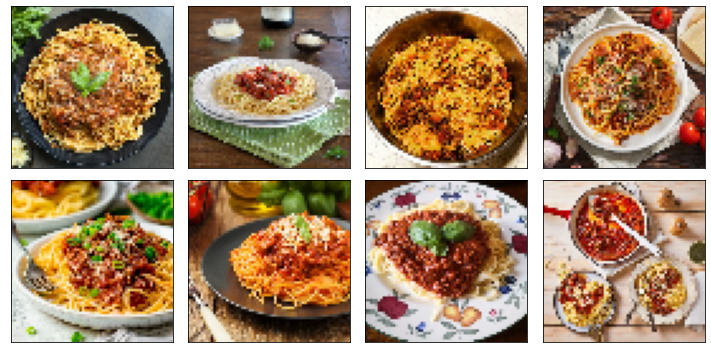

In [5]:
BATCH_SIZE = 8

root_dir = Path().cwd()/"downloaded_images"

dataset = tf.keras.utils.image_dataset_from_directory(root_dir,
                                                      labels=None,
                                                      image_size=(64, 64),
                                                      shuffle=False)
dataset_images = np.array(list(dataset.unbatch()))
dataset_images = dataset_images[:(dataset_images.shape[0] - dataset_images.shape[0] % BATCH_SIZE)]
dataset_images = np.array(tf_layers.Rescaling(1./255.)(dataset_images))

plt.rcParams['figure.figsize'] = [10, 5]
for i, image in enumerate(dataset_images[:8]):
    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.savefig('plots/sample_images.jpg')
plt.show()

# Experiments

## Test

In [7]:
GENERATOR_PATH_TO_LOAD = 'upsampling_model_checkpoints/generator/generator_3000'

generator = make_generator_with_upsampling()
generator.load_weights(GENERATOR_PATH_TO_LOAD)

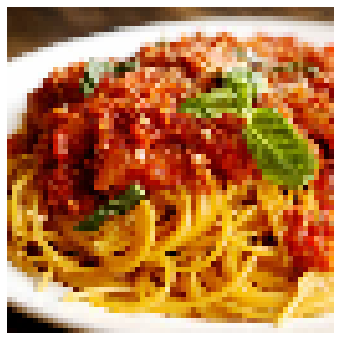

In [21]:
selected_image = dataset_images[13]

plt.rcParams['figure.figsize'] = [6, 6]
plt.imshow(selected_image)
plt.axis('off')
# plt.savefig('plots/experiments/upsampling_model/representative_image/real_image.jpg')
plt.show()

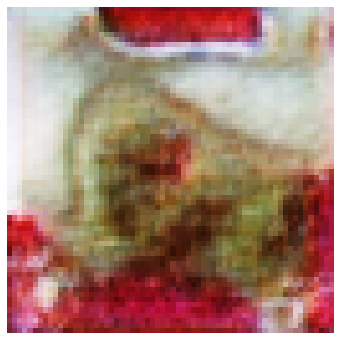

In [36]:
noise = tf.Variable(tf.random.normal((1, 128)))
generated_image = generator(noise, training=False)[0]

plt.imshow(generated_image)
plt.axis('off')
# plt.savefig('plots/experiments/first_model/representative_image/generated_image_0.jpg')
plt.show()

Epoch 10...
Epoch 20...
Epoch 30...
Epoch 40...
Epoch 50...
Epoch 60...
Epoch 70...
Epoch 80...
Epoch 90...
Epoch 100...
Epoch 110...
Epoch 120...
Epoch 130...
Epoch 140...
Epoch 150...
Epoch 160...
Epoch 170...
Epoch 180...
Epoch 190...
Epoch 200...
Epoch 210...
Epoch 220...
Epoch 230...
Epoch 240...
Epoch 250...
Epoch 260...
Epoch 270...
Epoch 280...
Epoch 290...
Epoch 300...
Epoch 310...
Epoch 320...
Epoch 330...
Epoch 340...
Epoch 350...
Epoch 360...
Epoch 370...
Epoch 380...
Epoch 390...
Epoch 400...
Epoch 410...
Epoch 420...
Epoch 430...
Epoch 440...
Epoch 450...
Epoch 460...
Epoch 470...
Epoch 480...
Epoch 490...
Epoch 500...


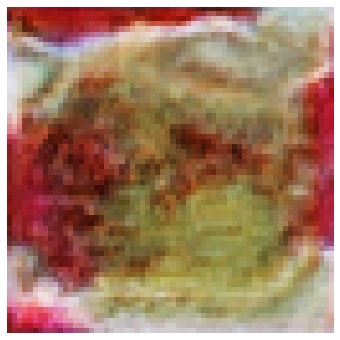

In [40]:
EPOCHS = 500

loss_fun = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

for i in range(1, EPOCHS + 1):
    if i % 10 == 0:
        print(f'Epoch {i}...')
    with tf.GradientTape() as tape:
        loss = loss_fun(selected_image, generator(noise, training=False))
        gradient = tape.gradient(loss, [noise])
        
    optimizer.apply_gradients(zip(gradient, [noise]))
       
    if i % 10 == 0:
        generated_image = generator(noise, training=False)[0]
        plt.imshow(generated_image)
        plt.axis('off')
#         plt.savefig('plots/experiments/first_model/representative_image/generated_image_{i}.jpg')
#         plt.clf()

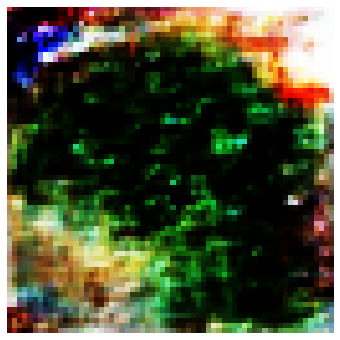

In [33]:
modified_noise = noise.numpy().copy()
for i in range(0, modified_noise.shape[1], 5):
    modified_noise[0][i] *= 5.
for i in range(0, modified_noise.shape[1], 7):
    modified_noise[0][i] /= 7.
    
generated_image = generator(modified_noise, training=False)[0]
plt.imshow(generated_image)
plt.axis('off')
plt.show()
# plt.savefig('plots/experiments/first_model/representative_image/generated_image_modified_noise.jpg')

## Four configurations

In [ ]:
IMAGE_IDX = 0
plt.imshow(dataset_images[IMAGE_IDX])
plt.axis('off')
None

In [ ]:
def handle_experiments(generator, base_image, experiment_path, n_epochs=50, report_step=10, print_report=False):
    plt.rcParams['figure.figsize'] = [6, 6]
    plt.imshow(base_image)
    plt.axis('off')
    plt.savefig(f'plots/experiments/{experiment_path}/real_image.jpg')
    
    noise = tf.Variable(tf.random.normal((1, 128)))
    generated_image = generator(noise, training=False)[0]

    plt.imshow(generated_image)
    plt.axis('off')
    plt.savefig(f'plots/experiments/{experiment_path}/generated_image_0.jpg')
    
    loss_fun = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

    for i in range(1, n_epochs + 1):
        if print_report and i % report_step == 0:
            print(f'Epoch {i}...')
        with tf.GradientTape() as tape:
            loss = loss_fun(image, generator(noise, training=False))
            gradient = tape.gradient(loss, [noise])

        optimizer.apply_gradients(zip(gradient, [noise]))

        if i % report_step == 0:
            generated_image = generator(noise, training=False)[0]
            plt.imshow(generated_image)
            plt.axis('off')
            plt.savefig(f'plots/experiments/{experiment_path}/generated_image_{i}.jpg')
            plt.clf()
            
    modified_noise = noise.numpy().copy()
    for i in range(0, modified_noise.shape[1], 5):
        modified_noise[0][i] *= 5.
    for i in range(0, modified_noise.shape[1], 7):
        modified_noise[0][i] /= 7.

    generated_image = generator(modified_noise, training=False)[0]
    plt.imshow(generated_image)
    plt.axis('off')
    plt.savefig(f'plots/experiments/{experiment_path}/generated_image_modified_noise.jpg')
    plt.clf()

In [ ]:
# TODO: unrelated image

# first model, representative image
generator = make_generator_model()
generator.load_weights('first_model_checkpoints/generator/generator_8')
handle_experiments(generator, dataset_images[IMAGE_IDX], 'first_model/representative_image')

# first model, unrelated image

# upsampling model, representative image
generator = make_generator_with_upsampling()
generator.load_weights('upsampling_model_checkpoints/generator/generator_8')
handle_experiments(generator, dataset_images[IMAGE_IDX], 'upsampling_model/representative_image')

# upsampling model, unrelated image